In [2]:
# --- Import Libraries ---
# Make sure to install these libraries in your environment:
# pip install ccxt pandas matplotlib
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [4]:
# --- Config ---
EXCHANGES = ['binance', 'bybit', 'coinbase']
SYMBOL = 'BTC/USDT'
TRADE_AMOUNT_BTC = 10 # Keeping trade size for comparison, but large in reality
# --- More Realistic Assumptions ---
TAKER_FEE_RATE = 0.001  # Assume 0.1% taker fee per leg (can be adjusted)
TRANSFER_FEE_BTC = 0.0005 # Estimated BTC cost to move funds for one arb cycle
SLIPPAGE_PERCENT = 0.0002 # Estimated 0.02% slippage per side (adjust based on market/size)
MIN_PROFIT_THRESHOLD_PERCENT = 0.05 # Keep the minimum threshold
# --- Date Range ---
START_DATE = '2023-01-01'
END_DATE = '2024-01-01' # Using the original end date

# --- Utility Functions ---
def date_to_timestamp(date_str):
    # Converts YYYY-MM-DD string to UTC milliseconds timestamp
    # Make sure to handle timezone properly, assuming UTC for consistency
    dt_obj = datetime.strptime(date_str, '%Y-%m-%d')
    # Assign UTC timezone explicitly before getting timestamp
    dt_obj_utc = pd.Timestamp(dt_obj, tz='UTC')
    return int(dt_obj_utc.timestamp() * 1000)


In [6]:
# --- MODIFIED Data Fetching Function ---
def fetch_minute_prices(exchange_id, symbol, since, until):
    """Fetches 1-minute OHLCV data with corrected pagination."""
    try:
        exchange_class = getattr(ccxt, exchange_id)()
        if not exchange_class.has['fetchOHLCV']:
            print(f"Exchange {exchange_id} does not support fetchOHLCV")
            return []
    except AttributeError:
         print(f"Exchange {exchange_id} not found in ccxt.")
         return []


    all_data = []
    # Ensure 'since' is properly handled if the exchange needs alignment
    timeframe_duration_ms = 60 * 1000 # 1 minute

    current_since = since

    # Add a safety break condition
    max_iterations = 10000 # Limit loops to prevent infinite loops on weird API behavior
    iterations = 0

    while current_since < until and iterations < max_iterations:
        iterations += 1
        try:
            # Fetch up to 1000 candles (or exchange limit) per request
            ohlcv = exchange_class.fetch_ohlcv(symbol, timeframe='1m', since=current_since, limit=1000)

            if not ohlcv:
                # No more data or break in data for this period
                # Need to advance timestamp to avoid getting stuck
                current_since += timeframe_duration_ms * 1000 # Advance significantly if no data found
                time.sleep(0.5) # Small delay
                continue # Try the next large interval

            # Filter data to be within the requested range [since, until)
            filtered_ohlcv = [entry for entry in ohlcv if entry[0] >= current_since and entry[0] < until]

            if not filtered_ohlcv:
                 # If all fetched data is outside the target window [current_since, until)
                 last_ts_in_batch = ohlcv[-1][0]
                 if last_ts_in_batch >= until:
                     # Fetched data is beyond the end date, we are done
                     break
                 else:
                     # Data is before current_since or there's a gap. Advance based on last fetched point.
                     current_since = last_ts_in_batch + timeframe_duration_ms
                     time.sleep(0.1) # Small delay before next fetch
                     continue


            for entry in filtered_ohlcv:
                # Basic validation: check if entry has expected length (6: ts, o, h, l, c, v)
                if len(entry) >= 5:
                     all_data.append({
                         'timestamp': pd.to_datetime(entry[0], unit='ms', utc=True), # Use UTC
                         'exchange': exchange_id,
                         'price': entry[4]  # Use close price
                     })
                else:
                     # print(f"Debug: Malformed entry from {exchange_id} at {entry[0]}: {entry}")
                     pass # Skip malformed entry

            # *** CORRECTED TIMESTAMP INCREMENT ***
            # Update 'since' for the next iteration based on the last valid timestamp processed + 1 minute
            last_ts_processed = filtered_ohlcv[-1][0]
            current_since = last_ts_processed + timeframe_duration_ms


            # Respect exchange rate limits if available
            if hasattr(exchange_class, 'rateLimit') and exchange_class.rateLimit is not None:
                 time.sleep(exchange_class.rateLimit / 1000)
            else:
                 time.sleep(0.2) # Default small delay if rateLimit not specified

        except ccxt.RateLimitExceeded as e:
            print(f"Rate limit exceeded for {exchange_id}, sleeping: {e}")
            time.sleep(10) # Wait longer if rate limited
        except ccxt.NetworkError as e:
            print(f"Network error fetching from {exchange_id}: {e}, retrying...")
            time.sleep(10) # Wait before retry on network error
        except ccxt.ExchangeNotAvailable as e:
            print(f"Exchange {exchange_id} not available: {e}. Skipping.")
            break # Stop fetching for this exchange
        except ccxt.ExchangeError as e:
             # Handle specific errors like invalid symbols, etc.
             if 'symbol' in str(e).lower() or 'market' in str(e).lower():
                  print(f"Symbol {symbol} likely invalid or unavailable on {exchange_id}: {e}")
             else:
                  print(f"Exchange error fetching from {exchange_id}: {e}")
             break # Stop fetching for this exchange on exchange error
        except Exception as e:
            print(f"Generic error fetching from {exchange_id} at timestamp {current_since}: {e}")
            # Potentially advance timestamp carefully or break
            current_since += timeframe_duration_ms # Cautiously advance
            time.sleep(1) # Wait after generic error

    if iterations >= max_iterations:
         print(f"Warning: Max iterations reached for {exchange_id}. Data might be incomplete.")

    return all_data

In [8]:
# --- Fetch Data ---
start_ts = date_to_timestamp(START_DATE)
end_ts = date_to_timestamp(END_DATE)

print(f"Fetching data from {START_DATE} ({start_ts}) to {END_DATE} ({end_ts})...")
price_data = []
for ex in EXCHANGES:
    print(f"Fetching from {ex}...")
    exchange_data = fetch_minute_prices(ex, SYMBOL, start_ts, end_ts)
    if exchange_data:
        price_data.extend(exchange_data)
        print(f"Fetched {len(exchange_data)} records from {ex}.")
    else:
        print(f"Warning: No data fetched from {ex} for the period.")

print("Data fetching complete. Processing...")

df_equity = pd.DataFrame(columns=['timestamp', 'equity']).set_index('timestamp') # Initialize empty
df_trades = pd.DataFrame() # Initialize empty

if not price_data:
    print("Error: No price data fetched from any exchange. Cannot proceed.")
    # Dataframes are already initialized as empty
else:
    df_raw = pd.DataFrame(price_data)
    # Ensure timestamp column exists and is suitable for indexing
    if 'timestamp' not in df_raw.columns:
        print("Error: Timestamp column missing in fetched data.")
        # Handle error or exit
    else:
        df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp']) # Ensure datetime objects
        df_raw = df_raw.set_index('timestamp')

        # Use pivot_table with an aggregate function (e.g., mean) to handle duplicates at the same timestamp/exchange
        try:
            df = df_raw.pivot_table(index='timestamp', columns='exchange', values='price', aggfunc='mean')
        except Exception as e:
            print(f"Error during pivot table creation: {e}")
            df = pd.DataFrame() # Set df to empty on error

        if df.empty and not df_raw.empty:
             print("Warning: Pivot table resulted in an empty DataFrame. Check raw data structure.")

        # Drop any rows where *any* exchange is missing data
        initial_rows = len(df)
        df = df.dropna(how='any') # Drop rows if any exchange price is NaN
        dropped_rows = initial_rows - len(df)
        print(f"Dropped {dropped_rows} rows with missing data after pivoting.")

        if df.empty:
             print("Error: Dataframe is empty after dropping NaNs. Check data fetching and date range.")
             # Keep df_equity and df_trades as empty initialized earlier
        else:
            # --- Backtest Logic ---
            equity = 0
            equity_curve = []
            trades = []
            print(f"Processed data shape for backtest: {df.shape}")
            print("Starting backtest...")
            start_backtest_time = time.time()

            for ts, row in df.iterrows():
                try:
                    # Ensure row contains valid numeric data before processing
                    if not pd.api.types.is_numeric_dtype(row):
                         equity_curve.append((ts, equity))
                         continue
                    if row.isnull().any(): # Double check for NaNs
                         equity_curve.append((ts, equity))
                         continue

                    best_ask_exchange = row.idxmin()
                    best_bid_exchange = row.idxmax()
                    ask = row[best_ask_exchange]
                    bid = row[best_bid_exchange]

                    # Skip if prices are invalid or zero
                    if not np.isfinite(ask) or not np.isfinite(bid) or ask <= 0 or bid <= 0:
                        equity_curve.append((ts, equity))
                        continue

                    # Skip if best bid isn't higher than best ask or same exchange
                    if bid <= ask or best_ask_exchange == best_bid_exchange:
                        equity_curve.append((ts, equity))
                        continue

                    # --- Apply Slippage ---
                    adjusted_ask = ask * (1 + SLIPPAGE_PERCENT)
                    adjusted_bid = bid * (1 - SLIPPAGE_PERCENT)

                    # Check again after slippage
                    if adjusted_bid <= adjusted_ask:
                         equity_curve.append((ts, equity))
                         continue

                    # --- Calculate Costs ---
                    # Trading Fees (Taker) - applied to adjusted prices
                    trading_fees_usdt = (adjusted_ask * TAKER_FEE_RATE + adjusted_bid * TAKER_FEE_RATE) * TRADE_AMOUNT_BTC

                    # Transfer Fees (Estimate) - convert BTC fee to USDT equivalent using avg adjusted price
                    avg_adjusted_price = (adjusted_ask + adjusted_bid) / 2
                    transfer_fee_usdt = TRANSFER_FEE_BTC * avg_adjusted_price

                    # --- Calculate Profit ---
                    gross_profit_usdt = (adjusted_bid - adjusted_ask) * TRADE_AMOUNT_BTC
                    net_profit_usdt = gross_profit_usdt - trading_fees_usdt - transfer_fee_usdt

                    # --- Check Profit Threshold ---
                    # Calculate profit % based on initial investment (using original ask before slippage)
                    initial_investment_usd = ask * TRADE_AMOUNT_BTC
                    if initial_investment_usd <= 0: # Avoid division by zero
                        profit_percent = 0
                    else:
                        # Profit percent calculated on net profit vs initial investment
                        profit_percent = (net_profit_usdt / initial_investment_usd) * 100

                    if profit_percent > MIN_PROFIT_THRESHOLD_PERCENT:
                        equity += net_profit_usdt
                        trades.append({
                            'timestamp': ts,
                            'buy_exchange': best_ask_exchange,
                            'sell_exchange': best_bid_exchange,
                            'buy_price_observed': ask, # Original observed price
                            'sell_price_observed': bid, # Original observed price
                            'buy_price_adjusted': adjusted_ask, # Price after slippage
                            'sell_price_adjusted': adjusted_bid, # Price after slippage
                            'trading_fees_usdt': trading_fees_usdt,
                            'transfer_fee_usdt': transfer_fee_usdt,
                            'net_profit_usdt': net_profit_usdt,
                            'profit_percent': profit_percent,
                            'invested_usd': initial_investment_usd
                        })

                except Exception as e:
                    print(f"Error processing row at {ts}: {type(e).__name__} - {e}")
                    equity_curve.append((ts, equity))
                    continue # Continue to next row


                # Record equity at each step, even if no trade
                equity_curve.append((ts, equity))

            end_backtest_time = time.time()
            print(f"Backtest finished in {end_backtest_time - start_backtest_time:.2f} seconds.")

            # --- Populate Equity DataFrame ---
            if equity_curve:
                 df_equity = pd.DataFrame(equity_curve, columns=['timestamp', 'equity'])
                 df_equity['timestamp'] = pd.to_datetime(df_equity['timestamp'])
                 df_equity = df_equity.set_index('timestamp')
            else:
                 # Keep df_equity as empty initialized earlier
                 print("Equity curve is empty after backtest loop.")


            # --- Populate Trades DataFrame ---
            if trades:
                df_trades = pd.DataFrame(trades)
            else:
                # Keep df_trades as empty initialized earlier
                print("No trades recorded during backtest.")


# --- Final Summary ---
total_pnl = 0
num_trades = 0
avg_profit_pct = 0
avg_net_profit_usd = 0

Fetching data from 2023-01-01 (1672531200000) to 2024-01-01 (1704067200000)...
Fetching from binance...
Fetched 525520 records from binance.
Fetching from bybit...
Fetched 525600 records from bybit.
Fetching from coinbase...
Fetched 357566 records from coinbase.
Data fetching complete. Processing...
Dropped 168107 rows with missing data after pivoting.
Processed data shape for backtest: (357493, 3)
Starting backtest...
Backtest finished in 58.42 seconds.



--- Backtest Summary ---
Period: 2023-01-01 to 2024-01-01
Exchanges: binance, bybit, coinbase
Symbol: BTC/USDT
Trade Amount (BTC): 10
Taker Fee Rate: 0.100%
Transfer Fee (BTC): 0.0005
Slippage Percent (per side): 0.020%
Min Profit Threshold: 0.050%
--------------------
Total Net PnL (USD): $187167.11
Number of Trades: 126
Average Profit per Trade: 0.545%
Average Net Profit per Trade (USD): $1485.45


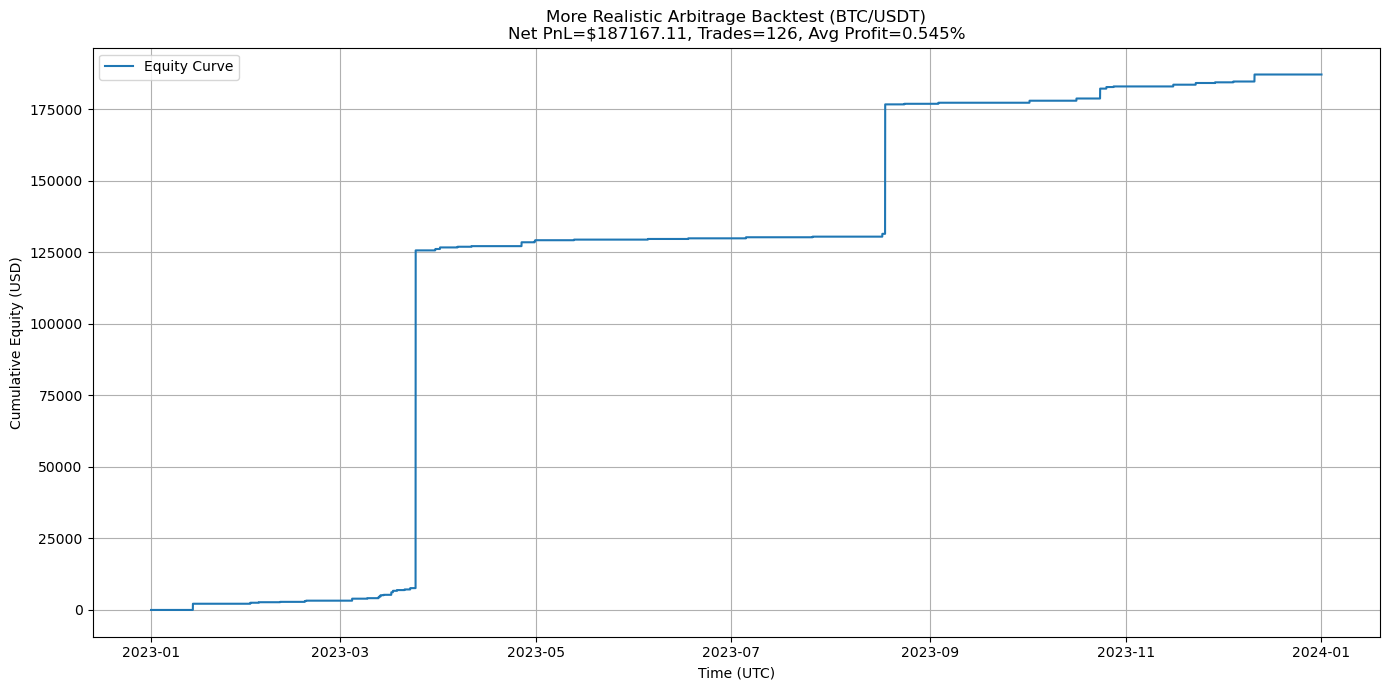

In [14]:
if not df_trades.empty:
    total_pnl = df_trades['net_profit_usdt'].sum()
    num_trades = len(df_trades)
    if num_trades > 0:
        avg_profit_pct = df_trades['profit_percent'].mean()
        avg_net_profit_usd = df_trades['net_profit_usdt'].mean()
    else:
         avg_profit_pct = 0
         avg_net_profit_usd = 0

print("\n--- Backtest Summary ---")
print(f"Period: {START_DATE} to {END_DATE}")
print(f"Exchanges: {', '.join(EXCHANGES)}")
print(f"Symbol: {SYMBOL}")
print(f"Trade Amount (BTC): {TRADE_AMOUNT_BTC}")
print(f"Taker Fee Rate: {TAKER_FEE_RATE*100:.3f}%")
print(f"Transfer Fee (BTC): {TRANSFER_FEE_BTC}")
print(f"Slippage Percent (per side): {SLIPPAGE_PERCENT*100:.3f}%")
print(f"Min Profit Threshold: {MIN_PROFIT_THRESHOLD_PERCENT:.3f}%")
print("-" * 20)

if num_trades > 0:
    print(f"Total Net PnL (USD): ${total_pnl:.2f}")
    print(f"Number of Trades: {num_trades}")
    print(f"Average Profit per Trade: {avg_profit_pct:.3f}%")
    print(f"Average Net Profit per Trade (USD): ${avg_net_profit_usd:.2f}")
else:
    print("No profitable trades found meeting the criteria with realistic adjustments.")


# --- Plot ---
plt.figure(figsize=(14, 7))
if not df_equity.empty:
    plt.plot(df_equity.index, df_equity['equity'], label='Equity Curve')
else:
    print("Cannot plot equity curve as it is empty.")

plt.title(f"More Realistic Arbitrage Backtest ({SYMBOL})\nNet PnL=${total_pnl:.2f}, Trades={num_trades}, Avg Profit={avg_profit_pct:.3f}%")
plt.xlabel("Time (UTC)")
plt.ylabel("Cumulative Equity (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
# --- Display Trade Log ---
print("\n--- Trade Log (First 100) ---")
if not df_trades.empty:
    # Select columns to display for brevity
    display_cols = ['timestamp', 'buy_exchange', 'sell_exchange',
                    'buy_price_adjusted', 'sell_price_adjusted', 'trading_fees_usdt',
                    'transfer_fee_usdt', 'net_profit_usdt', 'profit_percent']
    # Format floats for better readability
    pd.options.display.float_format = '{:.4f}'.format
    # Ensure timestamp is displayed nicely
    df_trades_display = df_trades.copy()
    df_trades_display['timestamp'] = df_trades_display['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    print(df_trades_display[display_cols].head(100).to_string(index=False))
else:
    print("No trades to display.")


--- Trade Log (First 100) ---
          timestamp buy_exchange sell_exchange  buy_price_adjusted  sell_price_adjusted  trading_fees_usdt  transfer_fee_usdt  net_profit_usdt  profit_percent
2023-01-14 00:38:00      binance      coinbase          20713.0418           20939.4013           416.5244            10.4131        1836.6575          0.8869
2023-01-14 00:39:00      binance      coinbase          20936.6965           20998.4195           419.3512            10.4838         187.3948          0.0895
2023-01-14 00:42:00      binance      coinbase          21213.8119           21271.9548           424.8577            10.6214         145.9493          0.0688
2023-01-31 22:50:00      binance      coinbase          23182.0855           23264.7261           464.4681            11.6117         350.3265          0.1511
2023-02-03 13:29:00     coinbase       binance          23434.1859           23500.5689           469.3475            11.7337         182.7492          0.0780
2023-02-10 05:3